In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In this section, we’ll build a model to classify Reuters newswires into $46$ mutually exclusive topics.

Because we have many classes, this problem is an instance of **multi-class classification**, and because each data point should be classified into only one category, the problem is more specifically an instance of **single-label multiclass classification**.

If each data point could belong to multiple categories (in this case, topics), we’d be
facing a _multilabel_ multiclass classification problem.

## The Reuters dataset
The Reuters dataset is a set of short newswires and their topics, published by Reuters in 1986.

There are $46$ different topics; some topics are more represented than others, but each topic
has at least $10$ examples in the training set.

The Reuters dataset comes packaged as part of Keras.

In [2]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)  # We arleady discussed the parameter 'num_words' in binary-classification

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

The label associated with an example is an integer between 0 and 45—a topic index:

In [6]:
train_labels[10]

np.int64(3)

## Preparing the data
### Encoding the input data
We can vectorize the data with the exact same code as in the previous example:

In [7]:
def vectorize_sequences(sequences, dimension=10000):
    # Creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.  # Sets specific indices to 1s
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

### Encoding the labels
To vectorize the labels, there are two possibilities:
- Casting the label list as an integer tensor
- **One-hot encoding**, a widely used format for categorical data, also called categorical encoding. It consists of embedding each label as an all-zero vector with a 1 in the place of the label index.

(In the previous example we used multi-hot encoding where we had multiple 1s in the vector)

In [8]:
# ONE-HOT ENCODING

# Manual Vectorization
# --------------------
# def to_one_hot(labels, dimension=46):
#     results = np.zeros((len(labels), dimension))
#     for i, label in enumerate(labels):
#         results[i, label] = 1.
#     return results

# y_train = to_one_hot(train_labels)
# y_test = to_one_hot(test_labels)

# Vectorization with Keras built-in function
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

If we chose to use the other approach, casting the labels to integer tensors with ```np.array```, the only thing that would change would be the choice of the loss function.

As you can see in the next section, we'll use ```categorical_crossentropy```, which expects the labels to follow a categorical encoding. With integer labels, you should use ```sparse_categorical_crossentropy```.

## Building the model
### Model definition
This topic-classification problem looks similar to the previous movie-review classification problem: in both cases, we’re trying to classify short snippets of text.

For this reason we'll use a similar architecture with three _Dense_ layers, but this time since the dimensionality of the output space is much larger ($46$ vs $2$), we'll need to increase the units in the first two layers to **$64$** to avoid bottlenecking.

Another difference is in the last layer activation function, this time we'll use **softmax** to output a _probability distribution_ over the $46$ different classes.

In [9]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

### Compiling the model
The best loss function to use in this case is ```categorical_crossentropy```.

It measures the distance between two probability distributions: here, between the probability distribution output by the model and the true distribution of the labels.

By minimizing the distance between these two distributions, you train the model to output something as close as possible to the true labels.

In [10]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training and validation
This section is very similar to the previous example, the only difference is in the size of the training and validation sets.

In [12]:
# Setting aside a validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [13]:
# Training the model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val))

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4605 - loss: 2.8725 - val_accuracy: 0.6290 - val_loss: 1.5016
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7060 - loss: 1.3082 - val_accuracy: 0.7550 - val_loss: 1.1542
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8036 - loss: 0.9263 - val_accuracy: 0.7850 - val_loss: 1.0174
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8581 - loss: 0.6697 - val_accuracy: 0.8020 - val_loss: 0.9544
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8845 - loss: 0.5488 - val_accuracy: 0.8150 - val_loss: 0.8991
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9131 - loss: 0.4076 - val_accuracy: 0.8080 - val_loss: 0.9034
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9339 - loss: 0.3082 - val_accuracy: 0.8270 - val_loss: 0.8741
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9437 - loss: 0.2615 - val_accuracy: 0.8250 - v

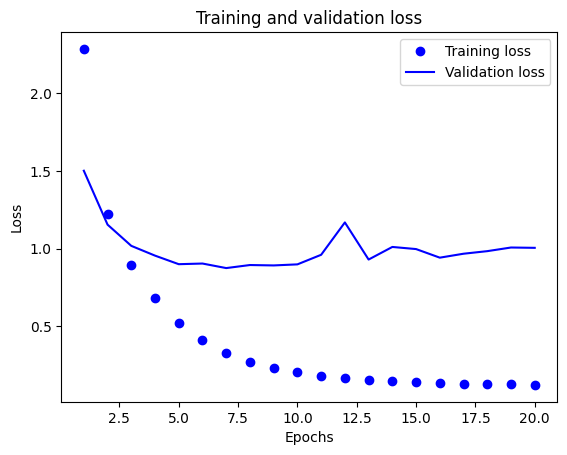

In [14]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

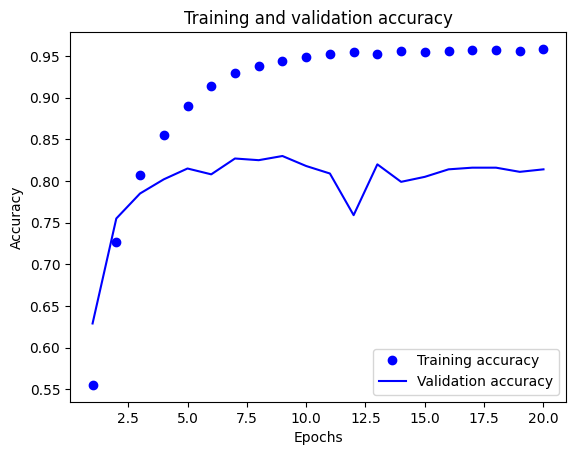

In [15]:
# Plotting the training and validation accuracy
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Retraining the model from scratch
The model begins to **overfit** after nine epochs, for this reason, as we did in the previous example, we train a new one for only nine epochs.

In [16]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3893 - loss: 3.2667
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6678 - loss: 1.6020
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7513 - loss: 1.1645
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7976 - loss: 0.9436
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8351 - loss: 0.7749
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8610 - loss: 0.6431
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8845 - loss: 0.5179
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9017 - loss: 0.4464
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9222 - loss: 0.3625
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7872 - loss: 0.9184


In [17]:
results

[0.930155336856842, 0.7836152911186218]

### Random Classifier comparison
This approach reaches an accuracy of **almost $80$%**. We can quickly check what would a random baseline accuracy be: 

In [18]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

np.float64(0.1861086375779163)

Only 19% !!!

## Generating predictions on new data
Calling the model’s predict method on new samples returns a class probability distribution over all $46$ topics for each sample:

In [19]:
predictions = model.predict(x_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Each entry in “predictions” is a vector of length $46$:

In [20]:
predictions[0].shape

(46,)

The coefficients in this vector sum to $1$, as they form a probability distribution:

In [21]:
np.sum(predictions[0])

np.float32(0.99999994)

The largest entry is the predicted class—the class with the highest probability:

In [27]:
np.argmax(predictions[0])

np.int64(3)

In [26]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])